In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


In [5]:
df_TB = pd.read_pickle("data/dades_TBert.pkl")
df_TB = df_TB.iloc[:, 2:]

In [6]:
x = df_TB.drop("Investment", axis=1)
x.columns = x.columns.astype(str)   #No se perquè, però si no ho faig em dona error
y = df_TB["Investment"]

In [7]:
print(x.shape)
print(y.shape)

(623, 884)
(623,)


Model de regressió normal i corrent

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)
print(reg.score(train_X,train_y))
print(reg.score(test_X,test_y))

Fatal, veiem que hi ha moltíssima variança en els paràmetres com a conseqüència d'un sobreajustament.
Podem utilitzar Lasso i Ridge regression per evitar-ho

Tenim molt poques dades, aleshores per cada lambda probarem centenars de possibles combinacions de de divisions de les dades en train i testing, aleshores al final farem la mitjana dels resultats i gaurdarem les dades a un dataframe, posteriorment escollirem el valor que fa tenir de mitjana uns resultats millors en el testing, de manera que trobarem el lambda que generalitza millor el model. Aleshores farem el model amb el 100% de les dades amb el lambda òptim

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge

results = []
c = 0
for i in np.linspace(1, 7, num=200):
    m = []
    n = []
    for r in range(1,201):
        print(f"{round((c+(r-1)/200)/200*100,1)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        lasso_reg = linear_model.Lasso(alpha=i, max_iter=100, tol=0.1)
        lasso_reg.fit(train_X, train_y)
        #print([i, ridge_reg.score(train_X, train_y), ridge_reg.score(test_X, test_y)])
        m.append(lasso_reg.score(train_X, train_y))
        n.append(lasso_reg.score(test_X, test_y))
    results.append([round(float(i), 3), round(float(np.mean(m)), 3), round(float(np.mean(n)), 3)])
    c = c+1

df_results_lasso = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean'])
print(df_results_lasso.loc[df_results_lasso['val_score_mean'].idxmax()])
df_results_lasso.to_pickle(path="data/lasso_TB.pkl")

#print(df_results_lasso)

alpha               4.158
train_score_mean    0.166
val_score_mean      0.092
Name: 10, dtype: float64


In [ ]:
df_results_lasso = pd.read_pickle("data/lasso_TB.pkl")
alpha = float(df_results_lasso['val_score_mean'].max())
lasso_reg = linear_model.Lasso(alpha=alpha, max_iter=1000, tol=0.01)
lasso_reg.fit(x, y)
lasso_reg.score(x, y)

0.41580682841175676

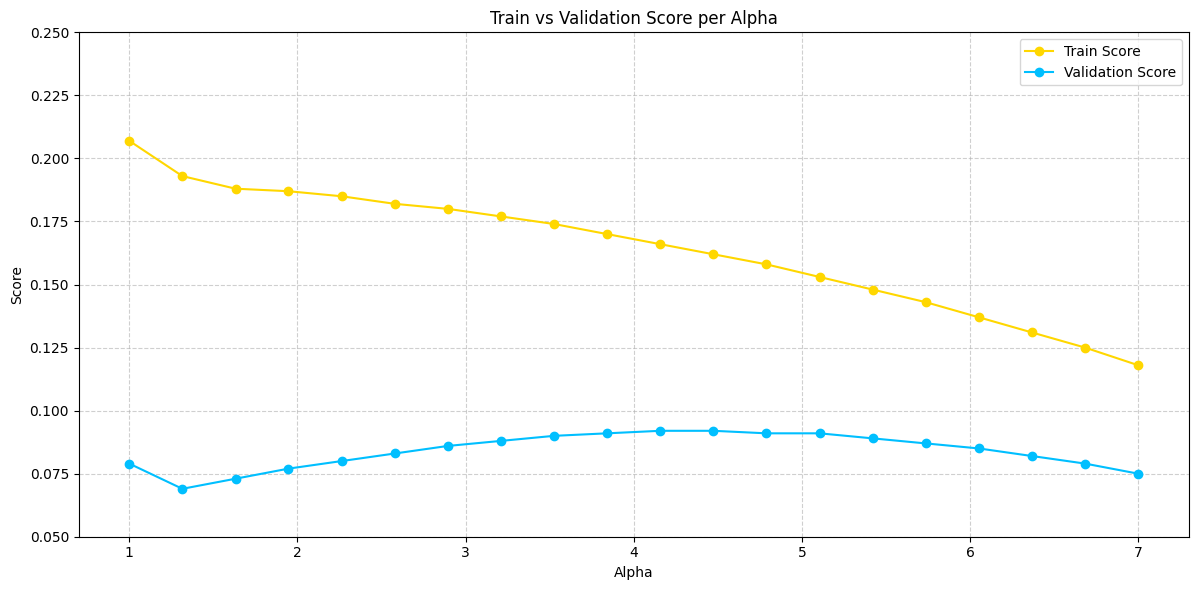

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_lasso['alpha']
train_scores = df_results_lasso['train_score_mean']
val_scores = df_results_lasso['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0.05, 0.25)

plt.show()


In [ ]:
results = []
c=0
for i in np.linspace(0.0001, 800, num=200):
    m = []
    n = []
    c = c+1
    print(f"{c/2}%", end='\r', flush=True)
    for r in range(1,250):
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        ridge_reg = linear_model.Ridge(alpha=i, max_iter=100, tol=0.1)
        ridge_reg.fit(train_X, train_y)
        #print([i, ridge_reg.score(train_X, train_y), ridge_reg.score(test_X, test_y)])
        m.append(ridge_reg.score(train_X, train_y))
        n.append(ridge_reg.score(test_X, test_y))
    results.append([round(float(i), 3), round(float(np.mean(m)), 3), round(float(np.mean(n)), 3)])

df_results_ridge = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean'])
print(df_results_ridge.loc[df_results_ridge['val_score_mean'].idxmax()])
#print(df_results_ridge)
df_results_ridge.to_pickle(path="data/ridge_TB.pkl")


In [ ]:
df_results_ridge = pd.read_pickle("data/ridge_TB.pkl")
alpha = float(df_results_ridge['val_score_mean'].max())
ridge_reg = linear_model.Lasso(alpha=alpha, max_iter=1000, tol=0.01)
ridge_reg.fit(x, y)
ridge_reg.score(x, y)

0.3277611929049016

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_ridge['alpha']
train_scores = df_results_ridge['train_score_mean']
val_scores = df_results_ridge['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0.05, 0.3)

plt.show()


Proposta: Crear una variable que et digui la quantitat de diners invertits previament, en comptes de les inversions

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

results = []
c = 0

# Busquem combinacions d'alpha i l1_ratio
alphas = np.linspace(0.0001, 800, num=100)
l1_ratios = np.linspace(0.0, 1.0, num=20)  # 0 = Ridge pur, 1 = Lasso pur

for l1_ratio in l1_ratios:
    for alpha in alphas:
        m = []
        n = []
        c += 1
        print(f"{100 * c / (len(alphas) * len(l1_ratios))}%", end='\r', flush=True)
        for r in range(1, 100): 
            train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000, tol=0.01)
            model.fit(train_X, train_y)
            m.append(model.score(train_X, train_y))
            n.append(model.score(test_X, test_y))
        results.append([round(alpha, 5), round(l1_ratio, 3), round(np.mean(m), 3), round(np.mean(n), 3)])

# Guardem resultats
df_results_elastic = pd.DataFrame(results, columns=['alpha', 'l1_ratio', 'train_score_mean', 'val_score_mean'])

# Millor combinació
best = df_results_elastic.loc[df_results_elastic['val_score_mean'].idxmax()]
print(best)

# Guardar i reutilitzar
df_results_elastic.to_pickle("data/elasticnet_TB.pkl")

In [ ]:

df_results_elastic = pd.read_pickle("data/elasticnet_TB.pkl")
best_alpha = float(best['alpha'])
best_l1 = float(best['l1_ratio'])

final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=1000, tol=0.01)
final_model.fit(x, y)
print("Final ElasticNet R²:", final_model.score(x, y))


Final ElasticNet R²: 0.09876336202807945


Una merda

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

talls = np.concatenate([np.arange(1, 101, 11)])

results_rf = []
c = 0

# Prova diferents valors de n_estimators (nombre d’arbres)
for n_estimators in talls:
    m = []
    n = []
    c += 1
    for r in range(1, 101):
        print(f"{round((c-1+(r-1)/100)*100/len(talls), 5)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        rf_reg = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf_reg.fit(train_X, train_y)
        m.append(rf_reg.score(train_X, train_y))
        n.append(rf_reg.score(test_X, test_y))
    results_rf.append([n_estimators, round(np.mean(m), 3), round(np.mean(n), 3)])

df_results_rf = pd.DataFrame(results_rf, columns=['n_estimators', 'train_score_mean', 'val_score_mean'])
print(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax()])

# Desa i recarrega si cal
df_results_rf.to_pickle(path="data/rf_TB.pkl")

n_estimators        11.000
train_score_mean     0.787
val_score_mean       0.529
Name: 1, dtype: float64


In [ ]:
df_results_rf = pd.read_pickle("data/rf_TB.pkl")

# Entrena el model final amb el millor n_estimators
best_n = int(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax(), 'n_estimators'])
rf_reg = RandomForestRegressor(n_estimators=best_n, random_state=42, n_jobs=-1)
rf_reg.fit(x, y)
print(rf_reg.score(x, y))


0.9066824723067429


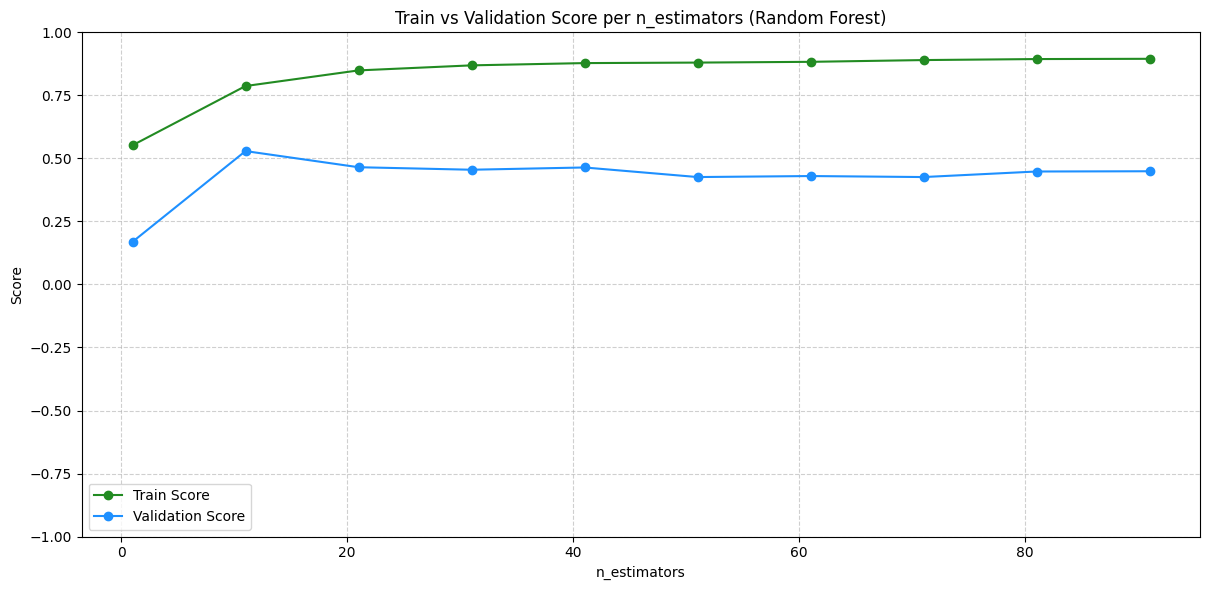

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del Random Forest
n_estimators = df_results_rf['n_estimators']
train_scores_rf = df_results_rf['train_score_mean']
val_scores_rf = df_results_rf['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(-1, 1) 

plt.show()


XGBoost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

results = []
c = 0
for i in np.arange(1, 30, 1):  # Pot ajustar-se segons dades
    m = []
    n = []
    for r in range(1, 101):  # Repeticions per fer mitjana
        print(f"{round(100 * (c+(r-1)/100)/30, 3)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        model = XGBRegressor(n_estimators=int(i), max_depth=6, learning_rate=0.1, verbosity=0)
        model.fit(train_X, train_y)
        m.append(model.score(train_X, train_y))
        n.append(model.score(test_X, test_y))
    results.append([int(i), round(np.mean(m), 3), round(np.mean(n), 3)])
    c += 1

df_results_xgb = pd.DataFrame(results, columns=['n_estimators', 'train_score_mean', 'val_score_mean'])
print(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax()])
df_results_xgb.to_pickle("data/xgb_TB.pkl")


In [ ]:
df_results_xgb = pd.read_pickle("data/xgb_TB.pkl")

best_n = int(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax(), 'n_estimators'])
model = XGBRegressor(n_estimators=best_n)
model.fit(x, y)
print(model.score(x, y))

0.8046881967068638


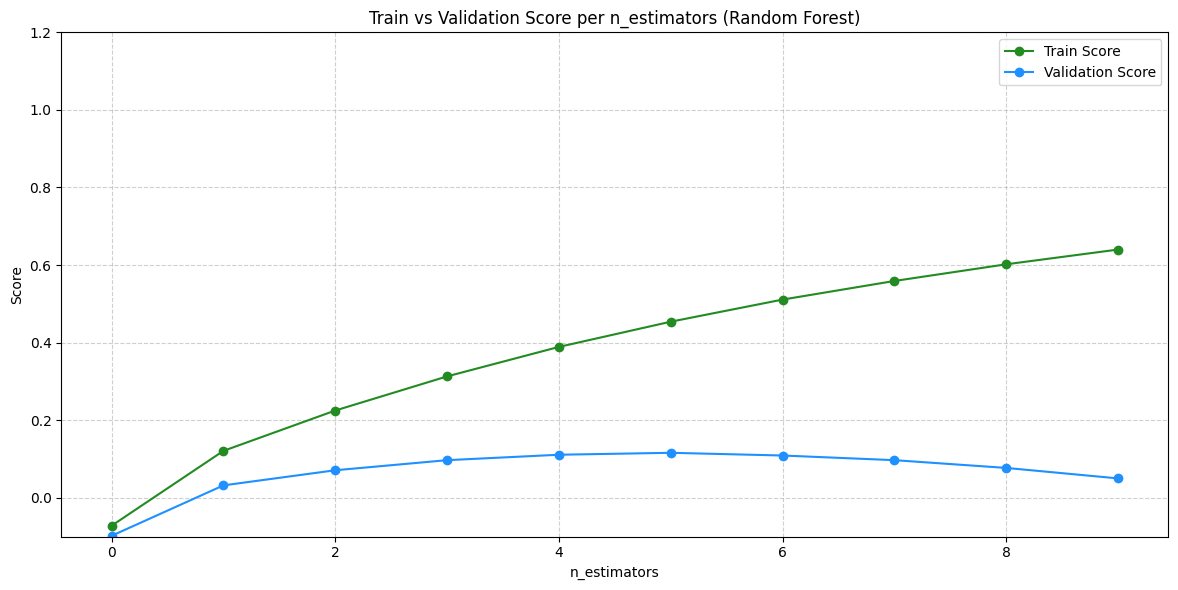

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del Random Forest
n_estimators = df_results_xgb['n_estimators']
train_scores_rf = df_results_xgb['train_score_mean']
val_scores_rf = df_results_xgb['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(-0.1, 1.2)

plt.show()


SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

results = []
c = 0
for i in np.linspace(0.0001, 200, num=400):  # pots ajustar el num si vols més resolució
    train_scores = []
    val_scores = []
    
    for r in range(1, 201):  # pots fer més o menys iteracions
        print(f"{round((c+(r-1)/200)/400*100, 2)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        
        svr_model = SVR(C=i, kernel='linear', epsilon=0.1, max_iter=1000)
        svr_model.fit(train_X, train_y)
        
        train_scores.append(svr_model.score(train_X, train_y))
        val_scores.append(svr_model.score(test_X, test_y))
    c += 1
    results.append([round(i, 4), np.mean(train_scores), np.mean(val_scores)])

# Guardem els resultats
df_results_svr = pd.DataFrame(results, columns=['C', 'train_score_mean', 'val_score_mean'])
print(df_results_svr.loc[df_results_svr['val_score_mean'].idxmax()])
df_results_svr.to_pickle("data/svr_TB.pkl")


C                   7.434400
train_score_mean    0.150715
val_score_mean      0.116399
Name: 46, dtype: float64


In [ ]:
df_results_svr = pd.read_pickle("data/svr_TB.pkl")
best_C = df_results_svr.loc[df_results_svr['val_score_mean'].idxmax(), 'C']
final_svr = SVR(C=best_C, kernel='linear', epsilon=0.1, max_iter=1000)
final_svr.fit(x, y)
print("Final SVR R² score:", final_svr.score(x, y))


Final SVR R² score: 0.12199221965372364


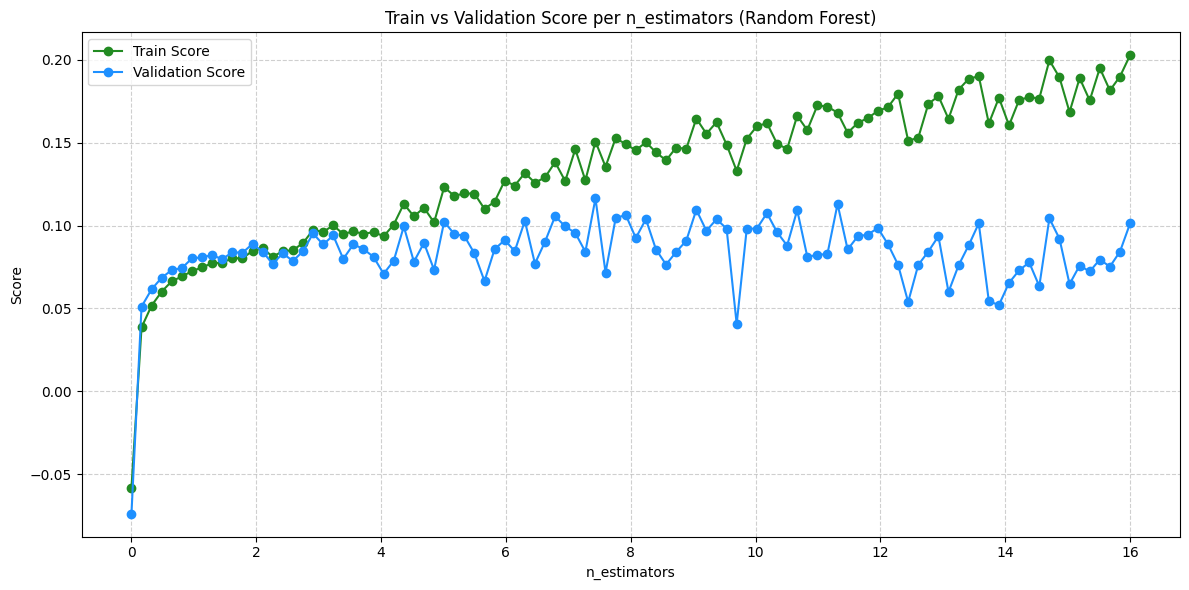

In [540]:
n_estimators = df_results_svr['C']
train_scores_rf = df_results_svr['train_score_mean']
val_scores_rf = df_results_svr['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(-0.3, 0.5)

plt.show()
